In [1536]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2556]:
df = pd.DataFrame.from_csv("../data/train_risk.csv", index_col=False)
test = pd.DataFrame.from_csv("../data/test_risk.csv", index_col=False)
X, y = df[df.columns[:-1]], df[df.columns[-1]]

## Analysing the Data

Looking at the difference between the number of positive and negative samples in the dataset shows that there are more negative examples than positive examples. Only 28% of all samples are of the positive class.

In [428]:
def class_balance_summary(y):
    """ Summarise the imbalance in the dataset"""
    total_size = y.size
    negative_class = y[y == 0].size
    positive_class = y[y > 0].size
    ratio = positive_class / float(positive_class + negative_class)

    print "Total number of samples: %d" % total_size
    print "Number of positive samples: %d" % positive_class
    print "Number of negative samples: %d" % negative_class
    print "Ratio of positive to total number of samples: %.2f" % ratio


class_balance_summary(y)

Total number of samples: 300
Number of positive samples: 84
Number of negative samples: 216
Ratio of positive to total number of samples: 0.28


Some initial observations about the data before it is preprocessed:
 - PRE32 is all zeros. This can be removed
 - PRE14 looks catagorical. Should be split into multiple binary variables
 - DGN looks catagorical. As above.
 - PRE5 looks to have some outliers. See box plot below. Potentially remove or split into two extra variable?

In [2391]:
X.head()

,DGN,PRE4,PRE5,PRE6,PRE7,PRE8,PRE9,PRE10,PRE11,PRE14,PRE17,PRE19,PRE25,PRE30,PRE32,AGE
0,3,2.08,1.52,1,0,0,0,1,0,4,0,0,0,1,0,49
1,3,4.36,3.76,0,0,0,0,0,0,1,0,0,0,1,0,72
2,3,3.52,2.28,0,0,0,0,0,0,3,0,0,0,1,0,51
3,3,3.36,2.67,1,0,0,0,1,0,1,0,0,0,1,0,72
4,3,3.56,2.80,0,0,0,0,0,0,2,0,0,0,0,0,69


Box plot below shows the outliers in PRE5. It is worth noting that all of these outliers are of the negative class. This variable is the volume that can be exhaled in one second given full inhilation. It is likely that these values are therefore errors in reporting as it is unlikely that humans can exhale such a large volume so quickly.

11     0
25     0
101    0
108    0
122    0
212    0
240    0
Name: Risk1Yr, dtype: int64


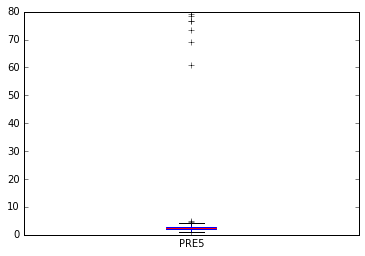

In [2241]:
X.PRE5.plot(kind='box')
print y[X.PRE5 > 30 ]

In [2248]:
X.DGN[y == 0].hist()
X.DGN[y == 1].hist()

## Preprocessing

Create a new matrix of preprocessed features. This will encode catagorical data as one hot vectors, remove outliers, and normalise the data.  

In [2557]:
from sklearn import preprocessing

def encode_onehot(x_data, column_name):
    """ Encode a catagorical column from a data frame into a data frame of one hot features"""
    enc = preprocessing.OneHotEncoder()
    features = enc.fit_transform(x_data[[column_name]]).toarray()
    names = ['%s_%d' % (column_name, i) for i in enc.active_features_]
    features = pd.DataFrame(features, columns=names, index=x_data.index)
    return features

def preprocess(x_data, y_data):
    # drop zero var PRE32
    Xp = x_data.drop("PRE32", axis=1)

    # remove outliers via median fill
    mask = Xp.PRE5 > 30  
    Xp.PRE5.loc[mask] = Xp.PRE5.median() 
    Yp = y_data.copy()
    
    # encode catagorical data as one hot vectors

    one_hot_names = ["DGN", "PRE6"]
    encoded = map(lambda name: encode_onehot(Xp, name), one_hot_names)
    #combine into a single data frame
    new_features = pd.concat(encoded, axis=1)

    # drop the catagorical variables that have been encoded
    Xp.drop(["DGN", "PRE6"], inplace=True, axis=1)
    # add new features
    Xp = pd.concat([Xp, new_features], axis=1)

    return Xp, Yp

Xp, Yp = preprocess(X, y)
Xp.head()

,PRE4,PRE5,PRE7,PRE8,PRE9,PRE10,PRE11,PRE14,PRE17,PRE19,...,DGN_1,DGN_2,DGN_3,DGN_4,DGN_5,DGN_6,DGN_8,PRE6_0,PRE6_1,PRE6_2
0,2.08,1.52,0,0,0,1,0,4,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,4.36,3.76,0,0,0,0,0,1,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,3.52,2.28,0,0,0,0,0,3,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,3.36,2.67,0,0,0,1,0,1,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,3.56,2.80,0,0,0,0,0,2,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x159e496d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x156b92410>]], dtype=object)

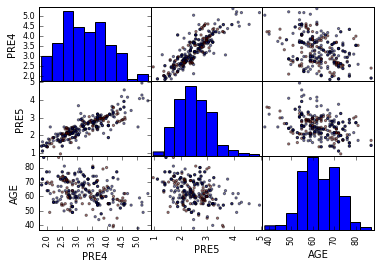

In [1539]:
pd.tools.plotting.scatter_matrix(Xp[['PRE4', 'PRE5', 'AGE']], c=Yp)

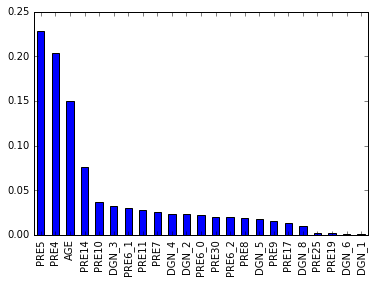

In [2239]:
rf_selector = RandomForestClassifier(criterion='entropy', class_weight='balanced')
rf_selector.fit(scaler.fit_transform(Xp), Yp)
feature_importance = pd.Series(rf_selector.feature_importances_, index=Xp.columns).sort_values(ascending=False)
feature_importance.plot(kind='bar')
Xp.drop(feature_importance[feature_importance == 0].index, inplace=True, axis=1)

## Learning

We do not have access to the labels for the final testing dataset. First split the training data into a training and validation set so we have something seperate to test on. Here we're using a  simple 80/20 split. Therefore the validation set contains 60 examples.

## Cross Validation and ROC Analysis

Set up models and pipelines for cross validation & testing. This is where we set the parameters for each of the models. Parameter tuning is done further down this notebook.

In [2669]:
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
import pipeline
from roc_analysis import ROCAnalysisScorer

scaler = preprocessing.StandardScaler()

# set up classifier objects
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')

gbc_params = {'n_estimators':1600, 'learning_rate': 0.005, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'subsample': 0.8, 'min_samples_split': 4, 'max_depth': 13}
gbc = GradientBoostingClassifier(**gbc_params)

rf_common_params = {'n_estimators':100, 'max_features':5}
exf = ExtraTreesClassifier( class_weight="balanced", **rf_common_params)
rf_balanced = RandomForestClassifier(class_weight='balanced_subsample', **rf_common_params)

# create pipelines for each model
knn_pipe = Pipeline([('scaler', scaler), ('KNN', knn)])
exf_pipe = Pipeline([('scaler', scaler), ('ExtraTrees', exf)])
gbc_pipe = Pipeline([('scaler', scaler), ('GradientBoostingClassifer', gbc)])
rfs_pipe = Pipeline([('scaler', scaler), ('RandomForest', rf_balanced)])

# create list of model data
models = [
    {'name': 'KNN', 'model': knn_pipe},
    {'name': 'ExtraTrees', 'model': exf_pipe},
    {'name': 'RandomForestBalanced', 'model': rfs_pipe},
    {'name': 'GradientBoost', 'model': gbc_pipe},
]

# set the same training set for all models.
# this is just the preprocessed dataset.
for model in models:
    model['train_data'] = (Xp, Yp)

Perform n iterations of k fold cross validation. Here I am using 10 iterations and 5 folds at each iteration.

In [2597]:
scorers = pipeline.repeated_cross_fold_validation(models, n=10, k=5)

Plot the resulting ROC curves. This is a averaged result of all n iterations and k folds, which should give a fairly stable estimate of each classifiers performance.

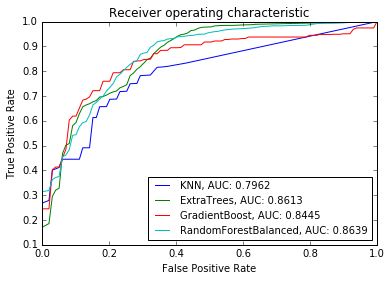

In [2598]:
for key, scorer in scorers.iteritems():
    scorer.plot_roc_curve(mean_label=key, mean_line=True, show_all=False)

## Tests with Oversampling

Testing whether using smote imporves the performance of Random Forest

In [2662]:
smote_params = {'kind': 'regular', 'k':3, 'ratio': 1.0, 'verbose': 1}
splitter = pipeline.SMOTESplitter(test_size=0.2, under_sample=0.4, smote_params=smote_params)
scorers = pipeline.monte_carlo_validation(Xp, Yp, models, splitter, n=5)

Determining classes statistics... 2 classes detected: {0: 173, 1: 67}
Finding the 3 nearest neighbours...done!
Creating synthetic samples...Generated 67 new samples ...
done!
Determining classes statistics... 2 classes detected: {0.0: 173, 1.0: 134}
Under-sampling performed: Counter({1.0: 134, 0.0: 53})
Determining classes statistics... 2 classes detected: {0: 173, 1: 67}
Finding the 3 nearest neighbours...done!
Creating synthetic samples...Generated 67 new samples ...
done!
Determining classes statistics... 2 classes detected: {0.0: 173, 1.0: 134}
Under-sampling performed: Counter({1.0: 134, 0.0: 53})
Determining classes statistics... 2 classes detected: {0: 173, 1: 67}
Finding the 3 nearest neighbours...done!
Creating synthetic samples...Generated 67 new samples ...
done!
Determining classes statistics... 2 classes detected: {0.0: 173, 1.0: 134}
Under-sampling performed: Counter({1.0: 134, 0.0: 53})
Determining classes statistics... 2 classes detected: {0: 173, 1: 67}
Finding the 3 n

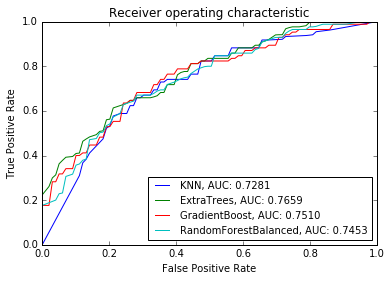

In [2663]:
for key, scorer in scorers.iteritems():
    scorer.plot_roc_curve(mean_label=key, mean_line=True, show_all=False)

## Tuning Models

Note that this section of the notebook and below can take a while to run due to the amount of fitting involved.

### Tuning Random Forest

In [2232]:
param_grid = [
  {'n_estimators': [100], 'max_features': [2, 3, 5, 7, 10], 'class_weight': ['balanced']},
 ]


clf = grid_search.GridSearchCV(RandomForestClassifier(), param_grid, cv=skf, scoring='roc_auc')
clf.fit(Xp, Yp)
clf.best_params_

{'class_weight': 'balanced', 'max_features': 5, 'n_estimators': 100}

### Tuning Gradient Boosting

First we should tune the number of estimators to a high learning rate for speed.

In [2377]:
const_params = {'min_samples_split': 1, 'min_samples_leaf': 3, 'max_depth': 8, 'max_features': 'sqrt', 'subsample': 0.8}
gbc = GradientBoostingClassifier(**const_params)

param_grid = [
   {'learning_rate': [0.1], 'n_estimators': range(20,81,10)}
 ]

clf = grid_search.GridSearchCV(gbc, param_grid, cv=skf, scoring='roc_auc')
clf.fit(Xp, Yp)
clf.best_params_

{'learning_rate': 0.1, 'n_estimators': 60}

Next we should tune the ```max_depth``` and ```min_samples_split``` parameters

In [2383]:
const_params = {'n_estimators':70, 'learning_rate': 0.1, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'subsample': 0.8}
gbc = GradientBoostingClassifier(**const_params)

param_grid = [
    {'max_depth':range(5,16,2), 'min_samples_split':range(1, 20, 3)}
 ]

clf = grid_search.GridSearchCV(gbc, param_grid, cv=skf, scoring='roc_auc')
clf.fit(Xp, Yp)
print clf.best_params_
clf.grid_scores_

{'min_samples_split': 4, 'max_depth': 13}


[mean: 0.79435, std: 0.03075, params: {'min_samples_split': 1, 'max_depth': 5},
 mean: 0.81461, std: 0.06848, params: {'min_samples_split': 4, 'max_depth': 5},
 mean: 0.78913, std: 0.05987, params: {'min_samples_split': 7, 'max_depth': 5},
 mean: 0.77216, std: 0.05531, params: {'min_samples_split': 10, 'max_depth': 5},
 mean: 0.79517, std: 0.04738, params: {'min_samples_split': 13, 'max_depth': 5},
 mean: 0.79232, std: 0.05012, params: {'min_samples_split': 16, 'max_depth': 5},
 mean: 0.78503, std: 0.06416, params: {'min_samples_split': 19, 'max_depth': 5},
 mean: 0.79297, std: 0.04892, params: {'min_samples_split': 1, 'max_depth': 7},
 mean: 0.82562, std: 0.05036, params: {'min_samples_split': 4, 'max_depth': 7},
 mean: 0.79596, std: 0.06681, params: {'min_samples_split': 7, 'max_depth': 7},
 mean: 0.80606, std: 0.05828, params: {'min_samples_split': 10, 'max_depth': 7},
 mean: 0.80783, std: 0.07548, params: {'min_samples_split': 13, 'max_depth': 7},
 mean: 0.81609, std: 0.07312, para